## RNN 语言模型

In [1]:
%load_ext watermark
%watermark -p tensorflow,numpy -v -m

CPython 3.4.3
IPython 5.3.0

tensorflow 1.0.1
numpy 1.12.0

compiler   : GCC 4.8.4
system     : Linux
release    : 4.9.8-moby
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
from collections import Counter
import time
import jieba
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 模型相关参数
filename = '../ch1/ZhangAiLing.txt'
file_read_size = 50000  # 设为0时读取全部文件
word_embedding_dim = 30
num_units = 30  # units of RNN cell
vocab_min_freq = 5  # 计入词表的最小词频
rnn_cell_type = 'LSTM'  # RNN cell 类型: 'vanilla', 'LSTM'

### 读取语料, 生成训练数据

In [4]:
PADDING = '<PAD>'
START = '<START>'  # 句首 token
UNKNOWN = '<UNK>'
VOCAB_SPECIAL = (PADDING, START, UNKNOWN)
END_PUNC = '。！？'  # 作为句子结束的符号
IGNORE = '\n “”"《》〈〉()*'  # 忽略不计的符号

In [5]:
def text2sentences(text):
    sentences = []
    sentence = []
    for word in jieba.cut(text):
        if word not in IGNORE:
            sentence.append(word)
        if word in END_PUNC:
            sentences.append(sentence)
            sentence = []
    return sentences

def prepend_start_token(sentences):
    return [[START] + sen for sen in sentences]

def build_vocab(sentences):
    """生成词表. 前几个位置留给 VOCAB_SPECIAL """
    vocab = list(VOCAB_SPECIAL)
    words_flat = [word for sen in sentences for word in sen]
    word_cnt = Counter(words_flat)
    for word, count in word_cnt.most_common():
        if count >= vocab_min_freq:
            vocab.append(word)
    return vocab

def word2id(word):
    if word not in vocab:
        word = UNKNOWN
    return word2id_dict[word]

def sentences2ids(sentences):
    return [[word2id(word) for word in s] for s in sentences]

In [6]:
with open(filename, encoding='utf-8') as f:
    text = f.read(file_read_size) if file_read_size else f.read()

sentences = text2sentences(text)
vocab = build_vocab(sentences)
vocab_size = len(vocab)
print('** vocab size = {} **'.format(vocab_size))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.706 seconds.
Prefix dict has been built succesfully.


** vocab size = 725 **


In [7]:
word2id_dict = {word: i for i, word in enumerate(vocab)}

sentences = prepend_start_token(sentences)
train_data = sentences2ids(sentences)

In [8]:
def generate_batch(train_data, batch_size):
    """生成 batch 训练数据.
    按 batch 内最大句长做 zero padding"""
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i+batch_size]
        max_len_of_batch = max([len(i) for i in batch])
        for j in range(len(batch)):
            batch[j].extend([0] * (max_len_of_batch - len(batch[j])))  # zero padding
        batch_data = np.asarray(batch)
        batch_inputs = batch_data[:, :-1]
        batch_labels = batch_data[:, 1:]
        yield batch_inputs, batch_labels

# 当 batch_size 等于总句数时, 得到的即为全体样本训练数据
all_inputs, all_labels = list(generate_batch(train_data, len(train_data)))[0]
all_inputs.shape, all_labels.shape

((1734, 82), (1734, 82))

### 构建 RNN

In [9]:
tf.reset_default_graph()

if rnn_cell_type == 'vanilla':
    cell = tf.contrib.rnn.BasicRNNCell(num_units)
elif rnn_cell_type == 'LSTM':
    cell = tf.contrib.rnn.BasicLSTMCell(num_units)
else:
    raise ValueError('Not a valid cell type')

word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))

# shape 第一个维度等于input/batch size, 第二个维度等于 句长-1
inputs = tf.placeholder(tf.int32, shape=[None, None], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None, None], name='labels')
labels_flat = tf.reshape(labels, (-1,))

input_embeds = tf.nn.embedding_lookup(word_embedding, inputs)

# 各句子中非零 id 的个数即为 sequence_length
sequence_length = tf.reduce_sum(tf.sign(inputs), axis=1)  
max_sequence_length = tf.reduce_max(sequence_length)
output, states = tf.nn.dynamic_rnn(cell, input_embeds, dtype=tf.float32, 
                                   sequence_length=sequence_length)
output_flat = tf.reshape(output, (-1, num_units))

softmax_w = tf.Variable(tf.random_uniform([num_units, vocab_size]))
softmax_b = tf.Variable(tf.random_uniform([vocab_size]))

logits_flat = tf.matmul(output_flat, softmax_w) + softmax_b
probs_flat = tf.sigmoid(logits_flat)
probs = tf.reshape(probs_flat, (-1, max_sequence_length, vocab_size))

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_flat, labels=labels_flat)

### 用 mask 修正 loss 函数

In [10]:
mask = tf.cast(tf.sign(labels_flat), tf.float32)
loss = tf.reduce_sum(losses * mask)

### 训练

In [20]:
# 训练相关参数
learning_rate = 0.1
batch_size = 10
epochs = 200
print_loss_every = 5

epoch    0: cost = 161407.1719
epoch    5: cost = 141290.4688
epoch   10: cost = 138211.0312
epoch   15: cost = 136674.0781
epoch   20: cost = 132048.2188
epoch   25: cost = 129770.1484
epoch   30: cost = 129553.0469
epoch   35: cost = 127569.4766
epoch   40: cost = 125211.4453
epoch   45: cost = 123705.5469
epoch   50: cost = 122868.9062
epoch   55: cost = 122875.9688
epoch   60: cost = 121130.2188
epoch   65: cost = 121980.0000
epoch   70: cost = 120480.8594
epoch   75: cost = 119347.8594
epoch   80: cost = 119441.8906
epoch   85: cost = 118570.5625
epoch   90: cost = 118275.2188
epoch   95: cost = 118049.4531
epoch  100: cost = 118011.9375
epoch  105: cost = 118158.5156
epoch  110: cost = 116956.1016
epoch  115: cost = 116689.2969
epoch  120: cost = 116656.5156
epoch  125: cost = 116419.5625
epoch  130: cost = 115851.2188
epoch  135: cost = 116344.6719
epoch  140: cost = 116051.1172
epoch  145: cost = 116261.9062
epoch  150: cost = 115502.2031
epoch  155: cost = 115737.3594
epoch  1

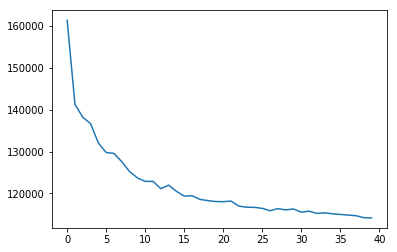

In [21]:
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
all_feed = {inputs: all_inputs, labels: all_labels}
loss_history = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())
start_time = time.time()
try:
    for i in range(epochs):        
        for inp, lab in generate_batch(train_data, batch_size):
            batch_feed = {inputs: inp, labels: lab}
            sess.run(train_step, feed_dict=batch_feed)
        if i % print_loss_every == 0:
            loss_val = sess.run(loss, feed_dict=all_feed)
            loss_history.append(loss_val)
            print('epoch {: 4d}: cost = {:.4f}'.format(i, loss_val))
except KeyboardInterrupt:
    print('KeyboardInterrupt')

end_time = time.time()
print('train time: {:.2f} s'.format(end_time - start_time))
plt.plot(loss_history);

### 用模型生成语句

生成一个句子的步骤:
* 由 句首token, 生成第一个词
* ...由已有的词生成下一个词...
* 直到生成 END_PUNC 为止.
* 如果生成了 UNK: 重新生成.

In [22]:
# 从三阶张量 probs 中提取出生成模型时下一个词的概率分布
probs_next_word = probs[0, -1, :]
probs_next_word.shape

TensorShape([Dimension(725)])

In [25]:
def generate_sentence(topk):
    word_ids = [word2id(START)]

    for i in range(100):  # 为句长设个上限
        context = np.asarray(word_ids).reshape(1, -1)
        probs_val = sess.run(probs_next_word, feed_dict={inputs: context})
        
        topk_indices = probs_val.argsort()[-topk:][::-1]
        topk_probs = [probs_val[i] for i in topk_indices]
        
        for j in range(100):  # 为尝试次数设个上限
            # 从概率最大的 topk 个词中随机抽取
            new_id = np.random.choice(topk_indices, p=topk_probs/sum(topk_probs))
            new_word = vocab[new_id]
            if new_word not in VOCAB_SPECIAL:
                break

        word_ids.append(new_id)
        if new_word in END_PUNC:
            break

    sentence = [vocab[i] for i in word_ids]
    return ''.join(sentence[1:])

for i in range(5):
    print('* ', generate_sentence(topk=20))

*  一面坐她他父亲怎么样是又问一脚吃着：那孩子了她忽然从曼桢看见…一鸣回来了是这样心还有没好？
*  沈到叔惠也觉得我母亲是去：嗳不大好房里？
*  世钧和叔惠生气，他的年纪也没有？
*  这一年：小健新还要不认识了上了他这他也不会。
*  啸桐在这里一个蓝布喜欢不来他家里在一起了来真在那里里上咐坐。


### ChangeLog

* VanillaRNN.v0:
    * 生成样例(topk=5):
        *  世钧也在茶杯难为情去看看。
        *  这你也也没有能。
        *  说了—，他们小姐不知道叔惠见她是他母亲便和世钧来到那里。
        *  这你也是因为面前什么？
        *  曼桢，叔惠的样子筷子看着世钧道火车给她是。
    * 从全部词表随机抽词时, 会抽出很奇怪的结果. 每步只抽概率 topk 的词, 效果要好一些.
    * 为啥 sigmoid 得到的 probs_val 求和不等于1?
    * 计算效率需要优化. 试图读入 10w 字时, notebook 会死掉. 这里的 sigmoid 能不能用 nce_loss 呢?
    * tf 的张量操作还不够熟悉, 有些张量操作应能用更简洁的方式实现
* LSTM.v0
    * 把 `tf.contrib.rnn.BasicRNNCell` 换成 `tf.contrib.rnn.BasicLSTMCell` 就可以了
    * 生成样例(topk=5):
        *  世钧的都相当多！
        *  曼桢也有点拘束事着，她倒是一个姨太太欠身向来也是这样的的一个人出去。
        *  世钧又要，他有一个孩子，他母亲也在那里。
        *  他倒是个狗上。
        *  她母亲笑起来去，他也没有他，世钧也知道她的气起来？
    * 生成样例(topk=20):
        *  但是因为再去在这一阵嘭笑声旧一趟很知道他自己道身上便在这儿一看不停。
        *  沈父亲又觉得太空了么嫂嫂！
        *  世钧道南京人？
        *  啸桐说她那个结果脾气进来水—我看看，他有是有点事；很高兴什么表示好几天到南京。
        *  在这里：爸爸刚才不去，怎么了一会么向来不会说了出来点怎么来见看看吧当差？
    * 另外, 词向量维数和 cell size 由30调到60, 没有明显效果.
* 下一步:
    * maybe: 更多语料 / 字模型 / ...
* 其他疑问:
    * tf.nn.dynamic_rnn 方法的 initial_state 参数默认为0, 是否意味着它会自动初始化一个 0 状态?